In [1]:
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import numpy as np
import random
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import MinMaxScaler
from pytorch_tabnet.augmentations import RegressionSMOTE
import matplotlib.pyplot as plt
from joblib import dump
import os

# Fix random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
sampler = TPESampler(seed=seed)

optuna.logging.set_verbosity(optuna.logging.WARNING)

HYPERPARAMETER_SEARCH = False

# Pre-processing input data

In [2]:
# train_df and test_df are created in eda notebook
if not os.path.exists('csv/train_df.csv') or not os.path.exists('csv/test_df.csv'):
	print('Please run the eda notebook first')
	exit()
train_df = pd.read_csv('csv/train_df.csv')
test_df = pd.read_csv('csv/test_df.csv')
target = 'total_time_target'
features = test_df.columns.copy().drop(target).drop(['benchmark','brand_raw', 'brand_raw_target','vendor_id_raw', 'arch'])

# Spearman U Kendall correlation feature selection > 0.4
# features = ["total_time","max_ram_usage","brk","munmap","rss","vms","shared","data"]
# mean error: 3.710890619668749 | std error: 10.002043224702053

# log for total_times
train_df[[target, 'total_time']] = np.log1p(train_df[[target, 'total_time']])
test_df[[target, 'total_time']] = np.log1p(test_df[[target, 'total_time']])

# Split data
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Normalize data
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

In [3]:
if not os.path.exists('../models/x_scaler.joblib') or not os.path.exists('../models/y_scaler.joblib'):
	dump(x_scaler, '../models/x_scaler.joblib')
	dump(y_scaler, '../models/y_scaler.joblib')

# Model: TabNet

In [4]:
def inv_scaling(y, y_scaler):
    return y_scaler.inverse_transform(y.reshape(-1, 1))

# Hyperparameters Optimization

In [7]:
def objective(trial: optuna.Trial, X_train, y_train, X_test, y_test):
	n_d = trial.suggest_int('n_d', 8, 64)
	n_steps = trial.suggest_int('n_steps', 3, 10)
	gamma = trial.suggest_float('gamma', 1.0, 2.0)
	n_independent = trial.suggest_int('n_independent', 1, 5)
	n_shared = trial.suggest_int('n_shared', 1, 5)
	momentum = trial.suggest_float('momentum', 0.01, 0.4)
	max_epochs = trial.suggest_int('max_epochs', 200, 1000)
	
	model = TabNetRegressor(
		n_d=n_d,
		n_a=n_d,
		n_steps=n_steps,
		gamma=gamma,
		n_independent=n_independent,
		n_shared=n_shared,
		momentum=momentum,
		verbose=0
	)

	aug = RegressionSMOTE(p=0.8)
	model.fit(
		X_train, y_train,
		eval_set=[(X_train, y_train), (X_test, y_test)],
		eval_name=['train', 'valid'],
		eval_metric=['rmse'],
		max_epochs=max_epochs,
		augmentation=aug,
	)

	validation_loss = model.best_cost_
	return validation_loss

n_trials = 25
study = None

In [8]:
if HYPERPARAMETER_SEARCH:
	study = optuna.create_study(direction='minimize', sampler=sampler)
	study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=n_trials)

In [9]:
if study is not None:
	print(f'Number of trials: {len(study.trials)}')
	trial = study.best_trial
	print(f'Best trial: {trial.number}')
	print(f'Best params: {trial.params}')
	print(f'Best validation loss: {y_scaler.inverse_transform(np.reshape(trial.value, (-1,1))).item()}')

# Training

In [10]:
# hyperparameters
if study is not None:
	params = study.best_trial.params
else:
	params = {
		"n_d": 8,
		"n_a": 8,
		"n_steps": 3,
		"gamma": 1.3,
		"n_independent": 2,
		"n_shared": 2,
		"momentum": 0.02,
		"max_epochs": 200,
	}

In [54]:
# single thread model initialization
aug = RegressionSMOTE(p=0.8)
model = TabNetRegressor(
	n_d=params["n_d"],
	n_a=params["n_a"],
	n_steps=params["n_steps"],
	gamma=params["gamma"],
	n_independent=params["n_independent"],
	n_shared=params["n_shared"],
	momentum=params["momentum"],
)
model.fit(
	X_train=X_train, 
	y_train=y_train,
	eval_set=[(X_train, y_train), (X_test, y_test)],
	eval_name=['train', 'valid'],
	eval_metric=['rmse'],
	augmentations=aug,
	max_epochs=params["max_epochs"],
)

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.13196 | train_rmse: 0.15626 | valid_rmse: 0.15137 |  0:00:03s
epoch 1  | loss: 0.00645 | train_rmse: 0.15498 | valid_rmse: 0.14993 |  0:00:06s
epoch 2  | loss: 0.00414 | train_rmse: 0.15367 | valid_rmse: 0.14805 |  0:00:09s
epoch 3  | loss: 0.00329 | train_rmse: 0.11246 | valid_rmse: 0.10453 |  0:00:12s
epoch 4  | loss: 0.00272 | train_rmse: 0.09473 | valid_rmse: 0.08938 |  0:00:16s
epoch 5  | loss: 0.00251 | train_rmse: 0.07298 | valid_rmse: 0.07096 |  0:00:19s
epoch 6  | loss: 0.00205 | train_rmse: 0.06065 | valid_rmse: 0.0578  |  0:00:22s
epoch 7  | loss: 0.0019  | train_rmse: 0.05211 | valid_rmse: 0.04921 |  0:00:25s
epoch 8  | loss: 0.00171 | train_rmse: 0.03867 | valid_rmse: 0.03315 |  0:00:28s
epoch 9  | loss: 0.00163 | train_rmse: 0.03351 | valid_rmse: 0.03296 |  0:00:31s
epoch 10 | loss: 0.00156 | train_rmse: 0.03155 | valid_rmse: 0.03125 |  0:00:34s
epoch 11 | loss: 0.0015  | train_rmse: 0.03735 | valid_rmse: 0.03397 |  0:00:37s
epoch 12 | loss: 0.0015  | t

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


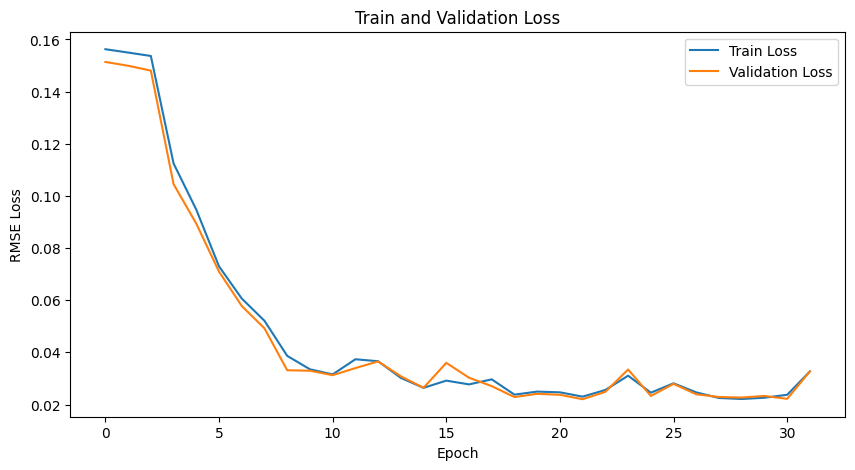

In [55]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(model.history["train_rmse"], label='Train Loss')
plt.plot(model.history["valid_rmse"], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')
plt.legend()
plt.show()

In [56]:
# save model
model.save_model('../models/tabnet_model')

Successfully saved model at ../models/tabnet_model.zip


'../models/tabnet_model.zip'

# Describe Validation

In [11]:
model = TabNetRegressor(
	n_d=params["n_d"],
	n_a=params["n_a"],
	n_steps=params["n_steps"],
	gamma=params["gamma"],
	n_independent=params["n_independent"],
	n_shared=params["n_shared"],
	momentum=params["momentum"],
)
model.load_model('../models/tabnet_model.zip')

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [12]:
def describe_val(model, X, y, y_scaler):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}
	predictions = model.predict(X)
	predictions = inv_scaling(predictions, y_scaler)
	y_scaled = inv_scaling(y, y_scaler)
	index_min = np.argmin(np.abs(predictions - y_scaled))
	min_instance["prediction"] = predictions[index_min].item()
	min_instance["actual"] = y_scaled[index_min].item()
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y_scaled))
	max_instance["prediction"] = predictions[index_max].item()
	max_instance["actual"] = y_scaled[index_max].item()
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions

In [13]:
def describe_val(model, X, y, y_scaler):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}
	predictions = model.predict(X)
	predictions = np.expm1(inv_scaling(predictions, y_scaler))
	y_scaled = np.expm1(inv_scaling(y, y_scaler))
	index_min = np.argmin(np.abs(predictions - y_scaled))
	min_instance["prediction"] = predictions[index_min].item()
	min_instance["actual"] = y_scaled[index_min].item()
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y_scaled))
	max_instance["prediction"] = predictions[index_max].item()
	max_instance["actual"] = y_scaled[index_max].item()
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions

In [14]:
test_df_og = pd.read_csv('csv/test_df.csv')

In [15]:
print("Validation set single thread model")
min_instance, max_instance, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test, y_scaler))
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model
Mean prediction: 22.32229995727539 | Std actual: 39.9256477355957
Mean actual: 23.401548499932737 | Std actual: 44.0307253488359
Mean Error: 3.517799597110904 | Std Error: 8.650772476582302
Min instance
total_time                                                            0.43
total_cpu_usage                                                       0.99
max_ram_usage                                                    39.441406
brand_raw                         Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz
vendor_id_raw                                                 GenuineIntel
arch                                                                X86_64
count                                                                   12
l2_cache_size                                                          1.5
l3_cache_size                                                         12.0
l2_cache_line_size                                                     256
l2_cache_ass

In [20]:
# get index of total_time_target < 2.00
index = test_df_og[test_df_og['total_time_target'] < 2.0].index
X_test_low = X_test[index]
y_test_low = y_test[index]
test_df_og_low = test_df_og.iloc[index].reset_index(drop=True)
min_instance, max_instance, predictions = describe_val(model, X_test_low, y_test_low, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test_low, y_scaler))
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Validation set single thread model with total_time_target < 2.0")
print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og_low.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og_low.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model with total_time_target < 2.0
Mean prediction: 0.7504633665084839 | Std actual: 0.5725892186164856
Mean actual: 0.7286966731898239 | Std actual: 0.5568325855632882
Mean Error: 0.13591400158370312 | Std Error: 0.15623660346872814
Min instance
total_time                                                            0.43
total_cpu_usage                                                       0.99
max_ram_usage                                                    39.441406
brand_raw                         Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz
vendor_id_raw                                                 GenuineIntel
arch                                                                X86_64
count                                                                   12
l2_cache_size                                                          1.5
l3_cache_size                                                         12.0
l2_cache_line_size                               

In [17]:
# get index of 2.00 > total_time_target > 150.0
index = test_df_og[(test_df_og['total_time_target'] <= 150.0) & (test_df_og['total_time_target'] >= 2.0)].index
X_test_med = X_test[index]
y_test_med = y_test[index]
test_df_og_med = test_df_og.iloc[index].reset_index(drop=True)
min_instance, max_instance, predictions = describe_val(model, X_test_med, y_test_med, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test_med, y_scaler))
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Validation set single thread model with total_time_target in [2.0, 150.0]")
print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og_med.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og_med.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model with total_time_target in [2.0, 150.0]
Mean prediction: 26.009567260742188 | Std actual: 22.179622650146484
Mean actual: 26.370051096444538 | Std actual: 22.30011708610565
Mean Error: 3.681226459127145 | Std Error: 4.260674531162838
Min instance
total_time                                                             2.63
total_cpu_usage                                                        0.99
max_ram_usage                                                     29.832031
brand_raw                          Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    56
l2_cache_size                                                          70.0
l3_cache_size                                                          42.0
l2_cache_line_size                 

In [19]:
# get index of total_time_target > 150.0
index = test_df_og[test_df_og['total_time_target'] > 150.0].index
X_test_high = X_test[index]
y_test_high = y_test[index]
test_df_og_high = test_df_og.iloc[index].reset_index(drop=True)
min_instance, max_instance, predictions = describe_val(model, X_test_high, y_test_high, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test_high, y_scaler))
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Validation set single thread model with total_time_target > 150.0")
print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og_high.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og_high.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model with total_time_target > 150.0
Mean prediction: 231.14511108398438 | Std actual: 46.50746536254883
Mean actual: 266.41856353591163 | Std actual: 12.794637910567783
Mean Error: 47.01559918651263 | Std Error: 23.40094574108351
Min instance
total_time                                                           274.27
total_cpu_usage                                                        0.99
max_ram_usage                                                          74.5
brand_raw                          Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    12
l2_cache_size                                                           1.5
l3_cache_size                                                          12.0
l2_cache_line_size                         